# FA

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

In [20]:
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'),
    "rdbchecksum": ('yes', 'no'),
    "rdb-save-incremental-fsync": ('yes', 'no'),

    "activedefrag": ('yes','no'),
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

In [21]:
# config data(.csv) -> DataFrame
config_df = pd.read_csv("./data/result_config0.csv", sep=',')

In [22]:
config_df['maxmemory']  = config_df['maxmemory'].str.strip('mb')

In [23]:
config_df['maxmemory'] = pd.to_numeric(config_df['maxmemory'])

In [24]:
# fillna(value = 0) 0 값으로 채워 넣기
config_df = config_df.fillna(value = 0)

In [25]:
category_knob = []

for knob in config_df:
    if config_df[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        config_df[knob] = config_df[knob].astype('category')
        category_knob.append(knob)


In [26]:
category_knob

['rdbcompression',
 'rdbchecksum',
 'rdb-save-incremental-fsync',
 'activedefrag',
 'maxmemory-policy',
 'lazyfree-lazy-eviction',
 'lazyfree-lazy-expire',
 'lazyfree-lazy-server-del',
 'activerehashing',
 'dynamic-hz']

In [27]:
# 카테고리컬 제거
config_df_dropped = config_df.drop(columns=category_knob)
config_df_dropped = config_df_dropped.drop(columns=['appendonly', 'appendfsync','auto-aof-rewrite-percentage', 'auto-aof-rewrite-min-size', 'no-appendfsync-on-rewrite', 'no-appendfsync-on-rewrite', 'aof-rewrite-incremental-fsync', 'aof-use-rdb-preamble'])
config_df_dropped

,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-samples,hash-max-ziplist-entries,hash-max-ziplist-value,hz
0,805,5,178,91,36,9230,23.0,84.0,24.0,72.0,2700,5,258,253,7
1,1097,3,499,33,82,9410,25.0,100.0,13.0,80.0,2200,3,360,226,32
2,1018,2,497,23,36,8649,17.0,79.0,30.0,71.0,1700,3,364,136,40
3,858,5,423,14,80,8407,12.0,77.0,17.0,89.0,1000,3,417,173,37
4,727,6,230,54,61,8327,9.0,87.0,13.0,85.0,1900,4,522,141,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,726,6,258,25,54,8545,13.0,100.0,21.0,86.0,2800,7,538,54,25
2496,930,8,166,98,50,10113,3.0,92.0,25.0,79.0,1500,4,735,67,7
2497,825,4,436,69,43,10806,25.0,98.0,3.0,75.0,2900,4,538,63,13
2498,1025,1,122,50,67,9759,1.0,75.0,26.0,74.0,2200,3,337,54,35


In [28]:
from sklearn.preprocessing import StandardScaler
config_df_scaled = StandardScaler().fit_transform(config_df_dropped)

config_df_scaled = pd.DataFrame(config_df_scaled, columns = config_df_dropped.columns, index = list(config_df_dropped.index.values))

In [29]:
config_df_scaled.head()

,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-samples,hash-max-ziplist-entries,hash-max-ziplist-value,hz
0,-0.780279,-0.000768,-1.062691,1.358170,-1.403396,-0.641402,1.535912,0.959439,1.624462,0.787033,1.285117,0.007108,-1.722876,1.667901,-1.136804
1,1.723914,-0.769250,1.704779,-0.876930,1.251229,-0.487309,1.738417,1.330847,0.518976,0.985129,0.427366,-1.414410,-1.013264,1.281451,1.002813
2,1.046410,-1.153490,1.687536,-1.262292,-1.403396,-1.138780,0.928400,0.843374,2.227454,0.762271,-0.430385,-1.414410,-0.985436,-0.006716,1.687491
3,-0.325751,-0.000768,1.049552,-1.609118,1.135810,-1.345949,0.422140,0.796948,0.920971,1.207986,-1.631237,-1.414410,-0.616717,0.522864,1.430736
4,-1.449207,0.383472,-0.614378,-0.067670,0.039335,-1.414435,0.118384,1.029078,0.518976,1.108938,-0.087285,-0.703651,0.113766,0.064849,0.831644


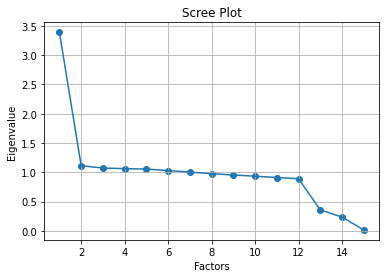

In [42]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors=4,rotation = 'varimax' )
fa.fit(config_df_scaled)  # fitting
config_df_fa = pd.DataFrame(fa.loadings_, index = config_df_scaled.columns)

ev, v = fa.get_eigenvalues()

# 요인수 구하기
plt.scatter(range(1,config_df_scaled.shape[1]+1),ev)
plt.plot(range(1,config_df_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [43]:
config_df_fa.head()

,0,1,2,3
save0_0,-0.010787,0.994067,0.080016,-0.020432
save0_1,-0.002501,-0.021290,-0.086734,0.157424
save1_0,0.025742,0.000235,-0.058437,0.007723
save1_1,0.006360,0.030342,0.081126,-0.036264
save2_0,-0.004705,-0.047322,0.035541,-0.064060


<AxesSubplot:>

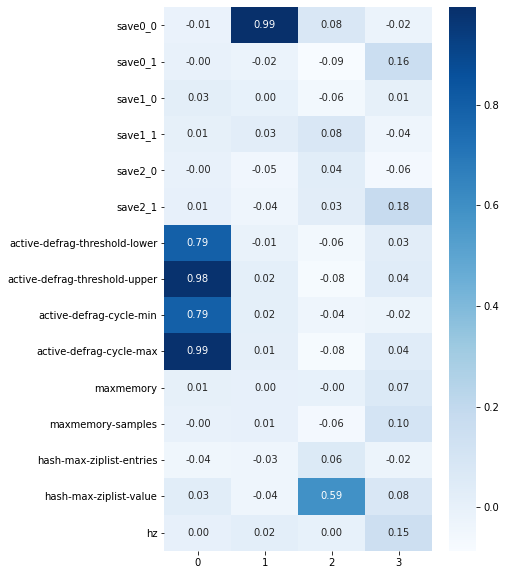

In [44]:
import seaborn as sns
plt.figure(figsize=(6,10))
sns.heatmap(config_df_fa, cmap="Blues", annot=True, fmt='.2f')

In [47]:
# 클러스터링 elbow
from sklearn.cluster import KMeans

def elbow(data, length):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, length):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, length), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()

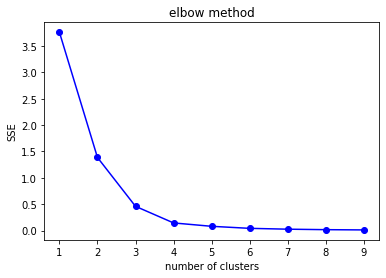

In [48]:
elbow(config_df_fa,10)

In [49]:
def kmeans(n_clusters, df):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(df)
    
    df['cluster'] = kmeans.labels_
    
    return df

# 클러스터 개수 확인 함수
def clusters(df):
    
    # 총 개수 확인
    print(df['cluster'].value_counts())
    print()
    
    count_cluster = len(df['cluster'].unique())
    new_df = pd.DataFrame()
    metric_list = []
    
    for i in range(count_cluster):
        metric_list = list(df[df['cluster'] == i].index)
        print("len = {}".format(len(df[df['cluster'] == i])))
        print("cluster{}".format(i))
        for metric in metric_list:
            print(metric)
        print()
        
    return new_df

In [55]:
kmeans_df = kmeans(3, config_df_fa)
df = clusters(kmeans_df)

0    5
2    5
1    5
Name: cluster, dtype: int64

len = 5
cluster0
save0_0
save1_0
save1_1
save2_0
hash-max-ziplist-entries

len = 5
cluster1
active-defrag-threshold-lower
active-defrag-threshold-upper
active-defrag-cycle-min
active-defrag-cycle-max
hash-max-ziplist-value

len = 5
cluster2
save0_1
save2_1
maxmemory
maxmemory-samples
hz

